## About Dataset
Photos of faces expressing different emotions.

Data divided into train(80%), test(10%), and validation(10%) sets in ImageFolder format.

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
num_classes = 7
# Load datasets
train_dataset = image_dataset_from_directory(
    os.path.join("kuvat/emotions/train"),
    image_size=(48, 48),
    batch_size=256
)
validation_dataset = image_dataset_from_directory(
    os.path.join("kuvat/emotions/val"),
    image_size=(48, 48),
    batch_size=256
)
test_dataset = image_dataset_from_directory(
    os.path.join("kuvat/emotions/test"),
    image_size=(48, 48),
    batch_size=256
)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),  # Lisää hieman enemmän pyöritystä
    layers.RandomZoom(0.2),  # Lisää enemmän zoomausta
    layers.RandomTranslation(0.2, 0.2),  # Lisää satunnaista siirtoa
    layers.RandomContrast(0.2)  # Lisää satunnaista kontrastin säätöä
])

# Kuvien esikäsittely: skaalataan arvot [0, 1] välille
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
validation_dataset = validation_dataset.map(lambda x, y: (x / 255.0, y))


Found 28709 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.


In [3]:
inputs = keras.Input(shape=(48, 48, 3))
x = layers.Flatten()(inputs)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,672,583 (14.01 MB)

 Trainable params: 3,672,583 (14.01 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:

callbacks = [
    EarlyStopping(
        patience=10,
        verbose=0,
        restore_best_weights=True,
        monitor="val_loss"
    ),
    ModelCheckpoint(
        filepath="emotions_CNN.keras",
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    )
]

start_time = time.time()

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

test_loss, test_acc = model.evaluate(test_dataset)

# Save results
np.savez("emotions_CNN.npz",
         test_acc=test_acc,
         test_loss=test_loss,
         training_time=training_time,
         history=history.history)

Epoch 1/10
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2029 - loss: 2.7738
Epoch 1: val_loss improved from inf to 1.79990, saving model to emotions_CNN.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.2033 - loss: 2.7622 - val_accuracy: 0.2491 - val_loss: 1.7999
Epoch 2/10
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2427 - loss: 1.8209
Epoch 2: val_loss improved from 1.79990 to 1.76728, saving model to emotions_CNN.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.2428 - loss: 1.8207 - val_accuracy: 0.2594 - val_loss: 1.7673
Epoch 3/10
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2546 - loss: 1.8013
Epoch 3: val_loss improved from 1.76728 to 1.74909, saving model to emotions_CNN.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.2546 - loss: 1.8011 - val_accuracy: 0.3143 - val_loss: 1.7491
Epoch 4/10
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2655 - loss: 1.7893
Epoch 4: val_loss did not improve from

In [5]:
test_model = keras.models.load_model(
    "emotions_CNN.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:3f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3287 - loss: 131.2930
Test accuracy: 0.333240


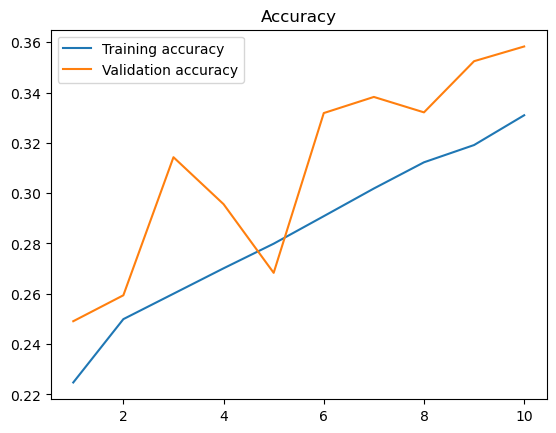

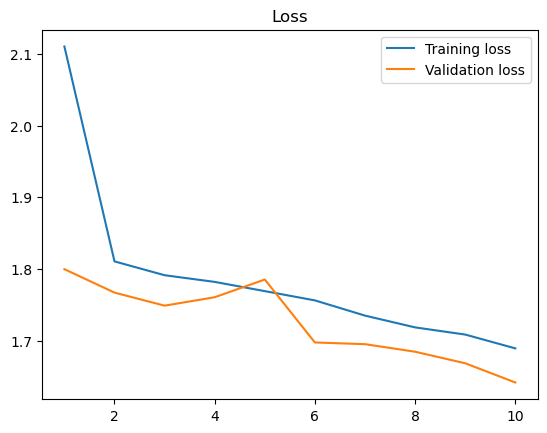

In [6]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = list(range(1, len(accuracy)+1))

plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Accuracy")
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.legend()
plt.title("Loss")
plt.show()


In [7]:

# Separate the images and labels into one numpy array
x_test = []
y_test = []

for images, labels in test_dataset:
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

# Combining batches into one large array
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(x_test.shape)  # esim. (N, 48, 48, 1)
print(y_test.shape)  # esim. (N,)



(3589, 48, 48, 3)
(3589,)


2025-04-27 15:32:44.309040: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:

# Ennustetaan kaikki testikuvat
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Alustetaan oikein
class_correct = [0 for _ in range(len(names))]
class_total = [0 for _ in range(len(names))]

# Lasketaan tarkkuus joka luokalle
for true_label, pred_label in zip(y_test, y_pred_labels):
    class_total[true_label] += 1
    if true_label == pred_label:
        class_correct[true_label] += 1

# Tulostetaan tulokset
for i in range(len(names)):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Accuracy of %5s : %2d %%' % (names[i], accuracy))
    else:
        print('No samples for class', names[i])


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy of Angry :  0 %
Accuracy of Disgust :  0 %
Accuracy of  Fear :  5 %
Accuracy of Happy : 73 %
Accuracy of   Sad :  5 %
Accuracy of Surprise : 66 %
Accuracy of Neutral : 33 %


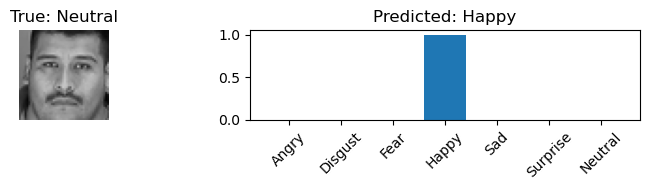

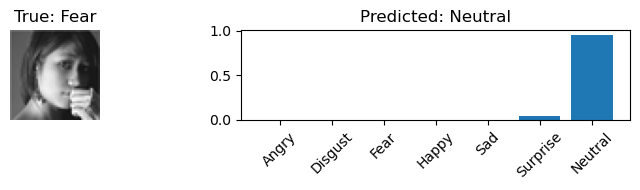

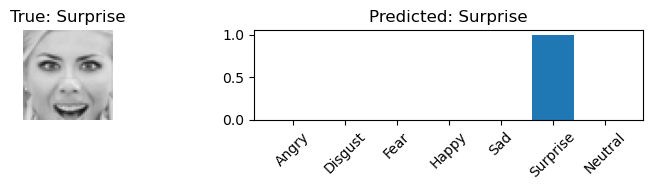

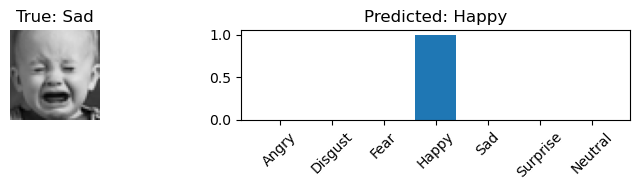

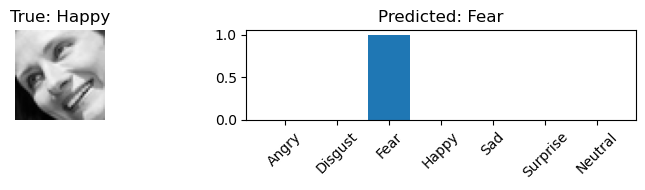

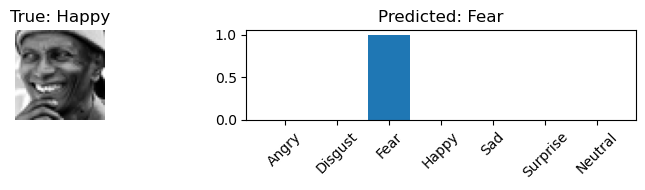

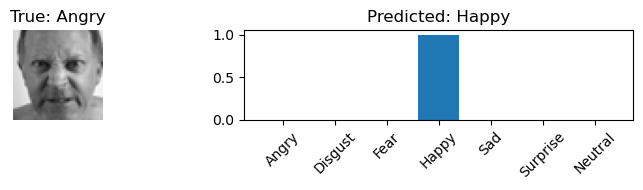

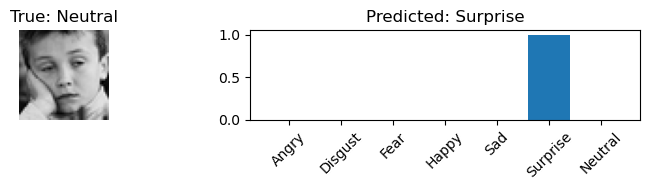

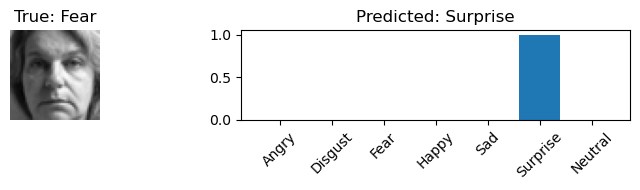

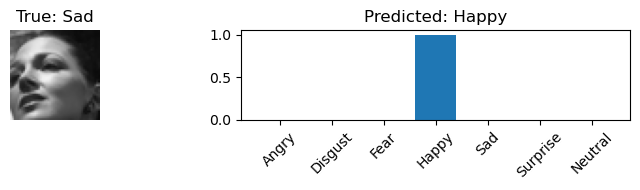

In [9]:

start = 2000

for k in range(10):
    plt.figure(figsize=(8, 2))

    # Plot the image (No 'cmap' needed for RGB images)
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[start + k].astype('uint8'))  # Ensure the pixel values are in the proper range
    plt.axis('off')
    true_label = names[y_test[start + k]]  # Get true label name
    plt.title(f"True: {true_label}")

    # Plot the predicted probabilities
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(len(names)), y_pred[start + k])
    predicted_class_index = np.argmax(y_pred[start + k])  # Find the predicted class
    predicted_class = names[predicted_class_index]  # Get predicted class name
    plt.title(f"Predicted: {predicted_class}")
    plt.xticks(np.arange(len(names)), names, rotation=45)  # Set the x-ticks with class names
    plt.tight_layout()
    plt.show()
